In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
y = snakemake_utils.get_dataset("small_pokec").get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [4]:
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_results/small_pokec/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['data_one/', 'data_two/', 'data_three/', 'data_four/', 'data_five/']
DATASET = 'small_pokec'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk"]

TEST_ADJ_FILE='/data/sg/ashutiwa/final_results/small_pokec/data_one/small_pokec_test_adj.npz'
NUM_NODES = 406898
k=5

data_five  data_one    data_two        roc_score.pkl
data_four  data_three  gini_score.pkl  sp_score.pkl


# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(TEST_ADJ_FILE)
NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True, iter_limit=2)
print("selected edge_idx size: {} for evaluation".format(EDGE_IDX.size(1)))

def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    positive_dot = np.array([np.dot(A[EDGE_IDX[0, i]], A[EDGE_IDX[1, i]]) for i in trange(EDGE_IDX.shape[1])])
    negative_dot = np.array([np.dot(A[NEGATIVE_EDGE_IDX[0, i]], A[NEGATIVE_EDGE_IDX[1, i]]) for i in trange(NEGATIVE_EDGE_IDX.shape[1])])
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

selected edge_idx size: 5973455 for evaluation


# GCN ( baseline)

In [8]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [01:50<00:00, 54010.28it/s]


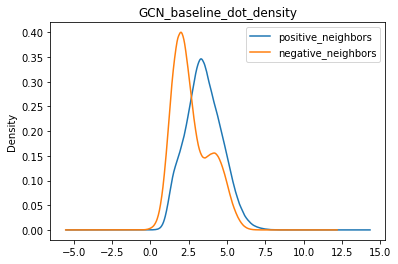

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 242.57it/s]


((2034490, 2), 3.067645466913217e-06, 0.6867389906838215, 0.07867976218915271)

# GCN ( baseline + crosswalk)

In [11]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
A = embs[model]
A.shape


(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:04<00:00, 47989.52it/s]


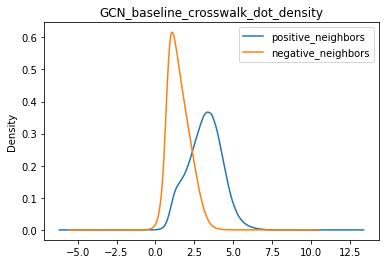

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 192.16it/s]


((2034490, 2), 3.083113464085922e-06, 0.8927796384509095, 0.07965057622033966)

# GCN ( r2v)

In [14]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:08<00:00, 46391.73it/s]


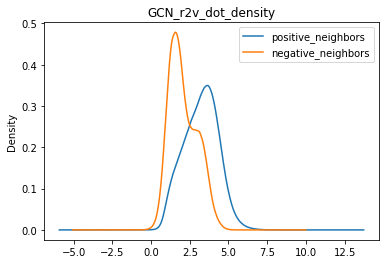

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 193.38it/s]


((2034490, 2), 3.068371254815531e-06, 0.7803891279670179, 0.07859421995725879)

# GCN ( r2v + crosswalk)

In [17]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:08<00:00, 46529.23it/s]


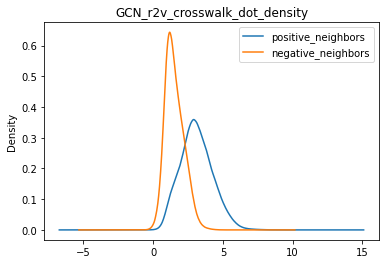

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 222.39it/s]


((2034490, 2), 3.0744451270651483e-06, 0.8801180456794835, 0.07962634687102986)

# GAT ( baseline)

In [20]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
A = embs[model]

A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:02<00:00, 48692.44it/s]


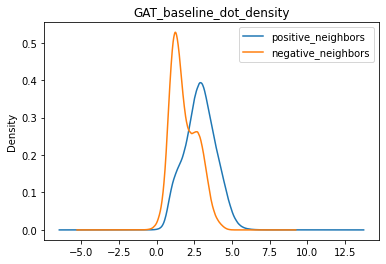

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 228.16it/s]


((2034490, 2), 3.071718882706274e-06, 0.7721855625433337, 0.07867397714053043)

# GAT ( baseline + crosswalk)

In [23]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:01<00:00, 49169.42it/s]


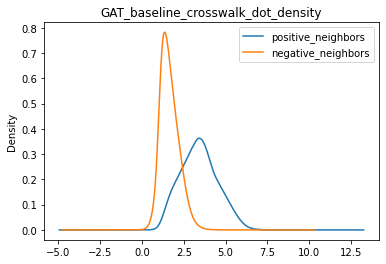

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 250.63it/s]


((2034490, 2), 3.0652469903355397e-06, 0.923260974020652, 0.07917057215260913)

# GAT ( r2v)

In [26]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:01<00:00, 49152.65it/s]


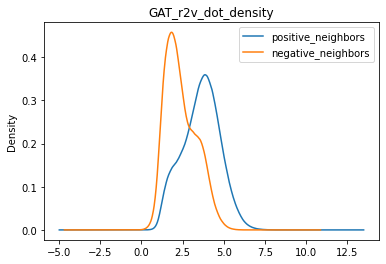

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 128.08it/s]


((2034490, 2), 3.0689524049234356e-06, 0.7863160381795371, 0.07846372564790387)

# GAT ( r2v + crosswalk)

In [29]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(406898, 128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5973455/5973455 [02:04<00:00, 47825.37it/s]


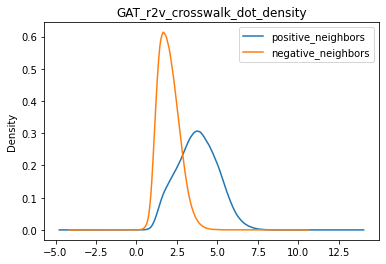

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 196.00it/s]


((2034490, 2), 3.051270315513175e-06, 0.8900735706510647, 0.07890781845347983)

# plot statistical parity scores

# gini sp scores

In [32]:

# for i, j in gini_score.items(): print(i, j)
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
# ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# ax.set_title("gini statistical parity scores")

# sp scores

In [33]:

# for i, j in sp_score.items(): print(i, j)
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
# ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# ax.set_title("statistical parity scores")

# roc auc scores

In [34]:

# for i, j in roc_score.items(): print(i, j)
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
# ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# ax.set_title("roc scores")

In [35]:

# N = 20

# sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
# for k in range(N):
#     for idx, m in enumerate(M):
#         if k == 0: continue
#         batch_size =  2000
#         A = embs[m]
#         edges = snakemake_utils.return_new_graph(A, k, )
        
    
#         gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
#         sp_scores[k, idx] = statistical_parity(edges, y, )


In [36]:
# for i in range(len(M)):
#     plt.plot(gini_scores[:, i], label=M[i])
# plt.legend(loc="upper right")
# plt.title("gini scores vs # nn")

In [37]:
# for i in range(len(M)):
#     plt.plot(sp_scores[:, i], label=M[i])
# plt.legend(loc="upper right")

# plt.title("sp scores vs # nn")

# combine all different runs

In [38]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        dot = create_dot_df(A)
        scores[idx] = get_roc_score(dot)
    return np.mean(scores)


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return np.mean(scores), np.mean(scores_gini)

In [ ]:

roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5967449/5973455 [02:06<00:00, 66490.03it/s]

In [ ]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: v[0] for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

In [ ]:
gini_score = {m: v[1] for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [ ]:
import pickle as pkl
# roc_score, sp_score, gini_score= {}, {}, {}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))